In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# --- Paths ---
image_dir = r"D:\B.Tech\8th Sem\CI Lab\Project\Cylone_Intensity_IndianOcean\Infrared"
csv_path = r"D:\B.Tech\8th Sem\CI Lab\Project\Cylone_Intensity_IndianOcean\label.csv"

# --- Load CSV ---
df = pd.read_csv(csv_path)
df['filepath'] = df['Filename'].apply(lambda x: os.path.join(image_dir, x))


In [3]:
# --- Train-Test-Validation Split ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [4]:
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 10872
Validation size: 1208
Test size: 3021


In [5]:
# --- Custom Dataset ---
class CycloneDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepath']
        label = float(self.dataframe.loc[idx, 'Vmax'])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# --- Image Transformations ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# --- Dataset and DataLoader ---
train_dataset = CycloneDataset(train_df, transform=transform)
val_dataset = CycloneDataset(val_df, transform=transform)
test_dataset = CycloneDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 340
Validation batches: 38
Test batches: 95


In [4]:
# --- CNN Model (Regression) ---
class CycloneCNN(nn.Module):
    def __init__(self):
        super(CycloneCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Model Setup ---
device = torch.device("cpu")
model = CycloneCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
import time

# --- First phase: Train for 10 epochs ---
initial_epochs = 10
total_epochs = initial_epochs  # For later extension

train_losses = []
val_losses = []

for epoch in range(1, total_epochs + 1):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch}/{total_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")

Epoch 1/10 | Train Loss: 541350.8292 | Val Loss: 50922.3524 | Time: 122.81s
Epoch 2/10 | Train Loss: 408854.7014 | Val Loss: 44550.3146 | Time: 100.15s
Epoch 3/10 | Train Loss: 386067.8175 | Val Loss: 44516.2520 | Time: 70.01s
Epoch 4/10 | Train Loss: 382415.4730 | Val Loss: 46583.2043 | Time: 70.08s
Epoch 5/10 | Train Loss: 380022.0191 | Val Loss: 43425.0502 | Time: 71.04s
Epoch 6/10 | Train Loss: 376306.5528 | Val Loss: 43264.7311 | Time: 70.18s
Epoch 7/10 | Train Loss: 372694.9642 | Val Loss: 43163.7773 | Time: 70.99s
Epoch 8/10 | Train Loss: 375322.1851 | Val Loss: 42355.0460 | Time: 70.05s
Epoch 9/10 | Train Loss: 369512.9299 | Val Loss: 43213.3107 | Time: 70.03s
Epoch 10/10 | Train Loss: 365478.3988 | Val Loss: 41950.2401 | Time: 70.11s


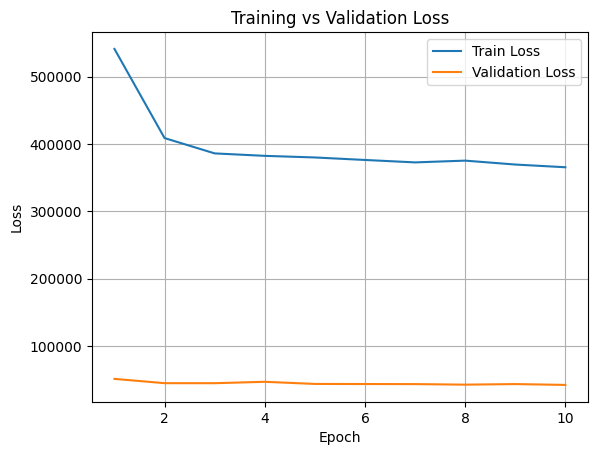

In [10]:
# --- Plot Loss Curves ---
plt.plot(range(1, initial_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, initial_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluate on Test Set ---
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(images)

        predictions.extend(outputs.squeeze().tolist())
        true_labels.extend(labels.squeeze().tolist())


In [11]:
# --- Metrics ---
mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"\n Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


 Test Set Evaluation:
Mean Squared Error (MSE): 1098.9182
Mean Absolute Error (MAE): 28.2205
R² Score: 0.0630


In [12]:
# --- Extend training: next 10 epochs ---
additional_epochs = 10
for epoch in range(total_epochs + 1, total_epochs + additional_epochs + 1):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")

# Update total_epochs
total_epochs += additional_epochs


Epoch 11 | Train Loss: 364240.6523 | Val Loss: 41165.3874 | Time: 81.69s
Epoch 12 | Train Loss: 359585.7729 | Val Loss: 40796.2967 | Time: 252.96s
Epoch 13 | Train Loss: 358449.5620 | Val Loss: 40496.8262 | Time: 149.32s
Epoch 14 | Train Loss: 350989.7013 | Val Loss: 39868.2205 | Time: 78.84s
Epoch 15 | Train Loss: 350135.9045 | Val Loss: 39680.0194 | Time: 82.27s
Epoch 16 | Train Loss: 343182.3471 | Val Loss: 39055.8174 | Time: 74.47s
Epoch 17 | Train Loss: 337752.0154 | Val Loss: 42531.5834 | Time: 69.09s
Epoch 18 | Train Loss: 336207.8910 | Val Loss: 38054.5153 | Time: 68.34s
Epoch 19 | Train Loss: 334631.2996 | Val Loss: 38326.1945 | Time: 68.64s
Epoch 20 | Train Loss: 325659.5323 | Val Loss: 37858.9615 | Time: 71.76s


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Evaluate on Test Set ---
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(images)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(true_labels, predictions)

print(f"Test Set Evaluation:")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Set Evaluation:
MAE : 24.3297
MSE : 971.6768
RMSE: 31.1717
R² Score: 0.0630


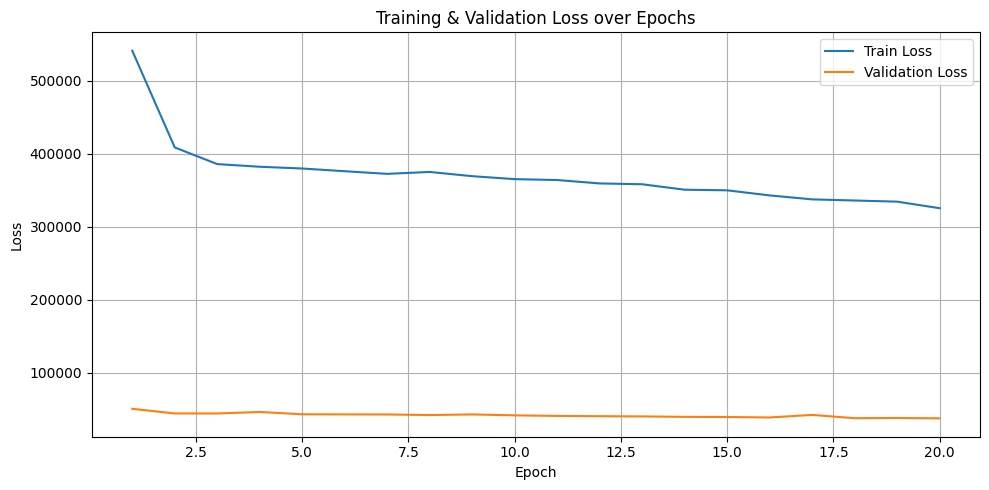

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Save model
model_save_path = "cyclone_cnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to cyclone_cnn_model.pth


C:\Users\satvi\AppData\Local\Temp\ipykernel_11344\559556723.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cyclone_cnn_model.pth", map

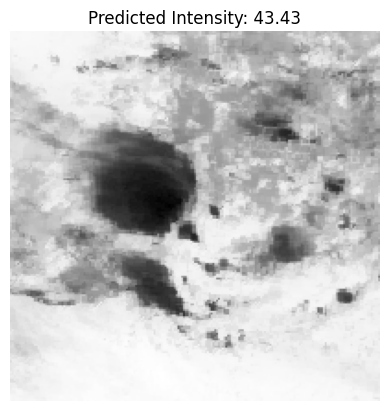

43.42824172973633

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# --- Load model ---
model = CycloneCNN().to(torch.device('cpu'))  # Use CPU
model.load_state_dict(torch.load("cyclone_cnn_model.pth", map_location=torch.device('cpu')))
model.eval()

# --- Define same transform as training ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# --- Predict for new image and display ---
def predict_intensity(image_path):
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Predict
    with torch.no_grad():
        prediction = model(input_tensor).item()

    # Show image
    plt.imshow(image)
    plt.title(f"Predicted Intensity: {prediction:.2f}")
    plt.axis('off')
    plt.show()

    return prediction

# --- Example usage ---
new_image_path = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_100.png"
predict_intensity(new_image_path)

In [20]:
# --- Extend training: next 40 epochs ---
additional_epochs = 40
for epoch in range(total_epochs + 1, total_epochs + additional_epochs + 1):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")

# Update total_epochs
total_epochs += additional_epochs


Epoch 21 | Train Loss: 322400.4506 | Val Loss: 37858.9615 | Time: 62.76s
Epoch 22 | Train Loss: 322290.0045 | Val Loss: 37858.9615 | Time: 69.53s
Epoch 23 | Train Loss: 322238.9519 | Val Loss: 37858.9615 | Time: 71.45s
Epoch 24 | Train Loss: 322257.7578 | Val Loss: 37858.9615 | Time: 71.82s
Epoch 25 | Train Loss: 322258.7200 | Val Loss: 37858.9615 | Time: 70.87s
Epoch 26 | Train Loss: 322363.7516 | Val Loss: 37858.9615 | Time: 77.95s
Epoch 27 | Train Loss: 322328.2860 | Val Loss: 37858.9615 | Time: 79.89s
Epoch 28 | Train Loss: 322419.0767 | Val Loss: 37858.9615 | Time: 71.19s
Epoch 29 | Train Loss: 322220.7138 | Val Loss: 37858.9615 | Time: 69.83s
Epoch 30 | Train Loss: 322309.3975 | Val Loss: 37858.9615 | Time: 70.01s
Epoch 31 | Train Loss: 322368.8122 | Val Loss: 37858.9615 | Time: 70.51s
Epoch 32 | Train Loss: 322298.7968 | Val Loss: 37858.9615 | Time: 69.99s
Epoch 33 | Train Loss: 322260.5136 | Val Loss: 37858.9615 | Time: 73.87s
Epoch 34 | Train Loss: 322250.4857 | Val Loss: 3785

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Evaluate on Test Set ---
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(images)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(true_labels, predictions)

print(f"Test Set Evaluation:")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Set Evaluation:
MAE : 24.3297
MSE : 971.6768
RMSE: 31.1717
R² Score: 0.0630


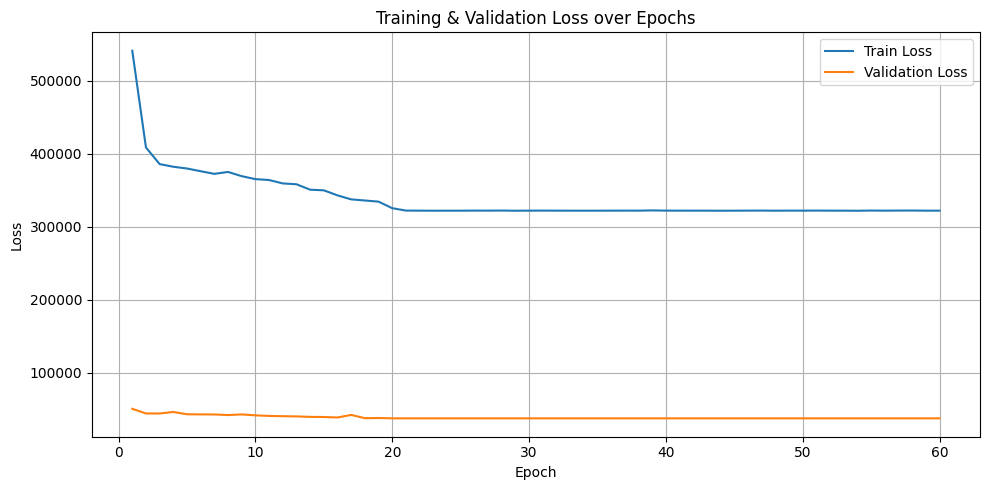

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Save model
model_save_path = "cyclone_cnn_model_2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to cyclone_cnn_model_2.pth


C:\Users\satvi\AppData\Local\Temp\ipykernel_19428\3193169245.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cyclone_cnn_model_2.pth", 

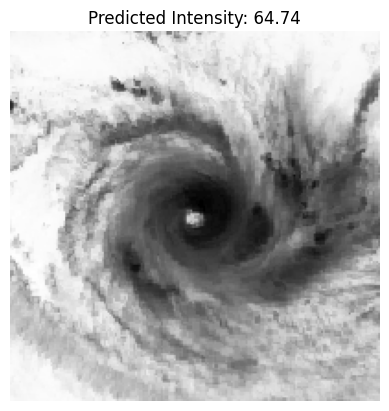

64.74490356445312

In [24]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# --- Load model ---
model = CycloneCNN().to(torch.device('cpu'))  # Use CPU
model.load_state_dict(torch.load("cyclone_cnn_model_2.pth", map_location=torch.device('cpu')))
model.eval()

# --- Define same transform as training ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# --- Predict for new image and display ---
def predict_intensity(image_path):
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Predict
    with torch.no_grad():
        prediction = model(input_tensor).item()

    # Show image
    plt.imshow(image)
    plt.title(f"Predicted Intensity: {prediction:.2f}")
    plt.axis('off')
    plt.show()

    return prediction

# --- Example usage ---
new_image_path = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_1.png"
predict_intensity(new_image_path)